In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError, MeanIoU

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
working_path = os.path.join(parent_dir) #incase directory needs to be expanded
downloads_path = os.path.expanduser("~\\Downloads")
extract_dir = os.path.expanduser("~\\Data_science")

In [3]:
# Set up folder paths
# Define the source paths for images and annotations
image_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'JPEGImages')
annot_pool_path = os.path.join(extract_dir, 'VOC_PCB', 'Annotations')

# Define the destination path for images and annotations
image_dest_path = os.path.join(working_path, 'data', 'Images')
annot_dest_path = os.path.join(working_path, 'data', 'Annotations')

# Define the path for RES_UNET model
model_loc = os.path.join(working_path, 'notebooks', 'models')


In [4]:
# Load the model
from tensorflow.keras.models import load_model
model_path = os.path.join(model_loc, 'model_enhanced_res_unet-v240618_3.keras')
'''
custom_objects = {
    #'focal_loss_fixed': focal_loss_fixed,
    #'DiceLoss': DiceLoss,
    'BinaryFocalCrossentropy': BinaryFocalCrossentropy,
    'CategoricalFocalCrossentropy': CategoricalFocalCrossentropy
}
'''
#model = load_model(model_path)#, custom_objects=custom_objects)

model = load_model(model_path, custom_objects={
    'MeanAbsoluteError': MeanAbsoluteError,
    'MeanIoU': MeanIoU,
    'Recall': Recall,
    'Precision': Precision
})

Testing on images outside of training and validation sets

In [196]:
filename = 'rotation_270_light_12_short_10_1_600.jpg'
image_test = []
if filename not in os.listdir(image_dest_path):
    image_test_path = os.path.join('C:/Users/wfaiz/Data_science/PCB_Defect/data_full/Images/', filename)
else:
    print('Image file is in training and validation dataset. Please provide new test image.')

In [197]:
if image_test_path:
    image_test = cv2.imread(image_test_path)

    if image_test is not None:
        image_test = cv2.resize(image_test, (600, 600))  # Resize
        gray_image = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)

        '''
        equalized_image = cv2.equalizeHist(gray_image)
        # Convert back to BGR format
        equalized_bgr = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)
        gray_image = cv2.cvtColor(equalized_bgr, cv2.COLOR_BGR2GRAY)
        # Increase brightness
        bright_image = cv2.convertScaleAbs(gray_image, alpha=1.1, beta=30)
        # blur filter to reduce glare
        glare_reduced_image = cv2.GaussianBlur(bright_image, (5, 5), 0)
        '''
        # Normalize the image
        image_array_test = np.asarray(gray_image) / 255.0

        '''
        For test images we do not have masks
        # Process the mask image
        mask_test_path = 'C:/Users/wfaiz/OneDrive/Desktop/Test_images_with_multiple_defects/pm-l_light_07_short_08_5_600.jpg'
        mask_test = cv2.imread(mask_test_path)

        if mask_test is not None:
            mask_test = cv2.resize(mask_test, (600, 600))  # Resize
            gray_mask = cv2.cvtColor(mask_test, cv2.COLOR_BGR2GRAY)
            mask_array_test = np.asarray(gray_mask) / 255.0  # Normalize
        else:
            print(f"Unable to read mask image from {mask_test_path}")
        '''
    else:
        print(f"Unable to read image from {image_test_path}")
else:
    print("No images found in the output directory.")

In [198]:
def crop_image(image, crop_size=(100, 100)):
    crops = []
    #print(image.shape)
    height, width = image.shape
    crop_height, crop_width = crop_size

    for i in range(0, height, crop_height):
        for j in range(0, width, crop_width):
            crop = image[i:i + crop_height, j:j + crop_width]
            if crop.shape[0] == crop_height and crop.shape[1] == crop_width:
                crops.append(crop)
    return crops

# Crop the normalized grayscale image into 100x100 sections
crops = np.asarray(crop_image(image_array_test, crop_size=(100, 100)))

In [199]:
y_pred, y_class = model.predict(crops)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [200]:
class_labels_pred = {
    0: 'missing_hole',
    1: 'mouse_bite',
    2: 'none',
    3: 'open_circuit',
    4: 'short',
    5: 'spur',
    6: 'spurious_copper'
}


In [201]:
predicted_label = np.argmax(y_class, axis=1)
remapped_label = [class_labels_pred[label] for label in predicted_label]

#debugging
#print("Remapped Labels:", remapped_label)

In [202]:
def combine_crops(crops, crop_size=(100, 100), full_size=(600, 600)):
    rows = full_size[0] // crop_size[0]
    cols = full_size[1] // crop_size[1]
    combined_image = np.zeros(full_size)

    crop_idx = 0
    for i in range(rows):
        for j in range(cols):
            combined_image[i*crop_size[0]:(i+1)*crop_size[0], j*crop_size[1]:(j+1)*crop_size[1]] = crops[crop_idx]
            crop_idx += 1
    return combined_image

In [203]:
X_test_combined = combine_crops(crops)
#y_test_mask_combined = combine_crops(y_pred3.squeeze())
y_mask_pred_combined = combine_crops(y_pred.squeeze())

In [204]:
output_image_path = os.path.join(downloads_path,'y_mask_pred_combined.png')

# Save the image
cv2.imwrite(output_image_path, y_mask_pred_combined)

True

In [205]:
# Preprocessing
def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    blurred = np.array(blurred, dtype=np.uint8)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh = np.array(thresh, dtype=np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    return thresh

In [206]:
# Detect and filter contours based on area
def detect_and_filter_contours(binary_image, min_contour_area):
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]
    bounding_boxes = []
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
    return filtered_contours, bounding_boxes

In [207]:
# Draw contours and bounding boxes on the image
def draw_contours(image, contours):
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for color drawing
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        #print(x, y, w, h)
        cv2.drawContours(output_image, [contour], -1, 255, -1)
        cv2.rectangle(output_image, (x, y), (x + w, y + h), 255, -1)
    return output_image

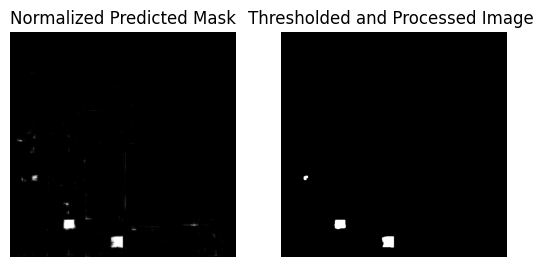

In [208]:
normalized_image = cv2.normalize(y_mask_pred_combined, 5, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
normalized_image = np.uint8(normalized_image)

# Preprocess the image
thresh = preprocess_image(normalized_image)

# Display the thresholded and processed image vs normalized image

plt.subplot(121) 
plt.imshow(normalized_image, cmap='gray')
plt.title("Normalized Predicted Mask")
plt.axis('off')
plt.subplot(122) 
plt.imshow(thresh , cmap='gray')
plt.title('Thresholded and Processed Image ')
plt.axis('off')
plt.show()

Number of contours found: 2


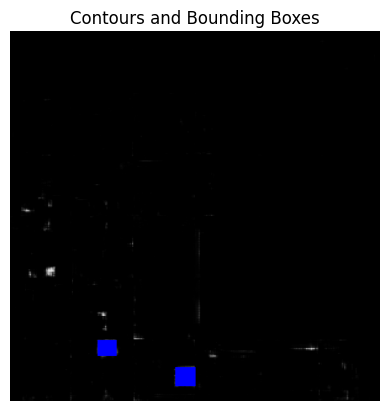

In [209]:
# Detect and filter contours because we do not want to detect mini defects
min_contour_area = 200  # Adjusting threshold based on requirements
filtered_contours, bounding_boxes = detect_and_filter_contours(thresh, min_contour_area)

print("Number of contours found:", len(filtered_contours))

output_image = draw_contours(normalized_image, filtered_contours)

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Contours and Bounding Boxes")
plt.axis('off')
plt.show()

In [210]:
def crop_and_resize_images(image, bounding_boxes, size=(100, 100)):
    cropped_images = []
    
    for bbox in bounding_boxes:
        #print("Bounding Box:", bbox)
        x, y, w, h = bbox
        cx = x + w // 2
        cy = y + h // 2
        #print("Center:", cx, cy)
        start_x = max(0, cx - size[0] // 2)
        start_y = max(0, cy - size[1] // 2)
        #print("Start Point:", start_x, start_y)
        start_x = min(start_x, image.shape[1] - size[0])
        start_y = min(start_y, image.shape[0] - size[1])
        #print("Adjusted Start Point:", start_x, start_y)
        end_x = start_x + size[0]
        end_y = start_y + size[1]
        #print("End Point:", end_x, end_y)
        cropped = image[start_y:end_y, start_x:end_x]
        #print("Cropped Shape:", cropped.shape)
        cropped_resized = cv2.resize(cropped, size, interpolation=cv2.INTER_LINEAR)
        #print("Resized Shape:", cropped_resized.shape)
        cropped_images.append(cropped_resized)
    return cropped_images

In [211]:
cropped_images = crop_and_resize_images(X_test_combined, bounding_boxes)

2


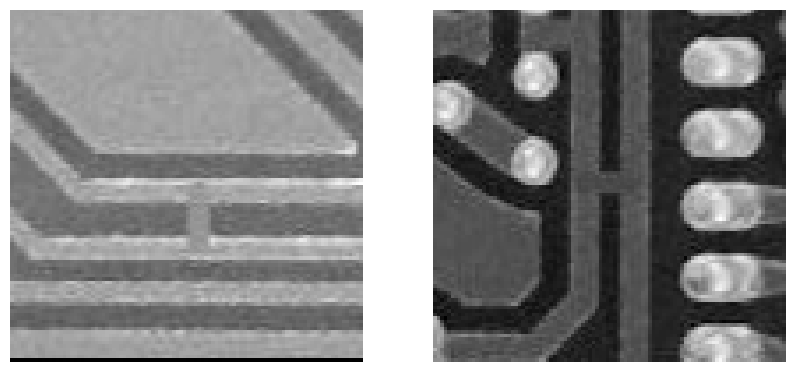

In [212]:
num_images = len(cropped_images)
print(num_images)
#fig, axs = plt.subplots(1, num_images, figsize=(10, 10))

#for i in range(num_images):
#    axs[i].imshow(cropped_images[i], cmap='gray') 
#    axs[i].axis('off')

#plt.show()

if num_images == 1:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(cropped_images[0], cmap='gray')
        ax.axis('off')
        plt.show()
else:
    fig, axs = plt.subplots(1, num_images, figsize=(10 , 10))
    for i in range(num_images):
        axs[i].imshow(cropped_images[i], cmap='gray')
        axs[i].axis('off')
    plt.show()

The model needs to predict the class of defect from the predicted segmentation area for accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Remapped Labels for image 0: ['short']


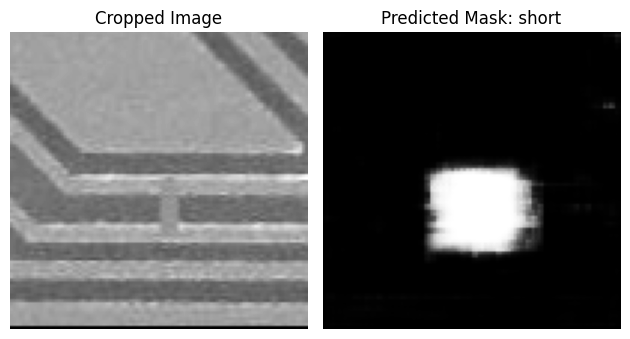

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Remapped Labels for image 1: ['short']


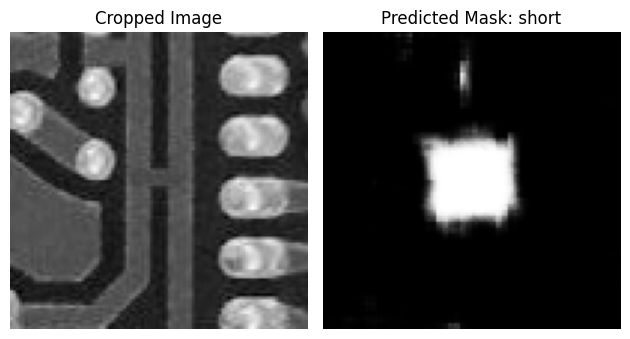

In [213]:
y_mask_pred = []
y_class_pred = []
pred_label = []
remapped_pred_label = []

for i in range(num_images):
    cropped_image = cropped_images[i]
    cropped_image = np.expand_dims(cropped_image, axis=0)  # Add batch dimension
    #cropped_images_batch = np.expand_dims(cropped_images[i], axis=0)
    #print(cropped_images_batch.shape)
    y_mask_pred_i, y_class_pred_i = model.predict(cropped_image)

    y_mask_pred.append(y_mask_pred_i)
    y_class_pred.append(y_class_pred_i)

    pred_label_i = np.argmax(y_class_pred_i, axis=1)
    remapped_pred_label_i = [class_labels_pred[label] for label in pred_label_i]

    pred_label.append(pred_label_i)
    remapped_pred_label.append(remapped_pred_label_i)

    # debugging testprint
    print(f"Remapped Labels for image {i}: {remapped_pred_label_i}")

    plt.subplot(121) 
    plt.imshow(cropped_image.squeeze(), cmap='gray')
    plt.title('Cropped Image')
    plt.axis('off')

    plt.subplot(122) 
    plt.imshow(y_mask_pred_i.squeeze(), cmap='gray')
    plt.title(f'Predicted Mask: {remapped_pred_label_i[0]}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
                      

Occasionally, the identified defect that has been segmented belongs to the 'none' class, indicating an erroneous detection. Therefore, it is necessary to filter out defects classified as 'none' from the predictions.

In [214]:
normalized_image = cv2.normalize(y_mask_pred_combined, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
normalized_image = np.uint8(normalized_image)
thresh = preprocess_image(normalized_image)
filtered_contours, bounding_boxes = detect_and_filter_contours(thresh, min_contour_area)

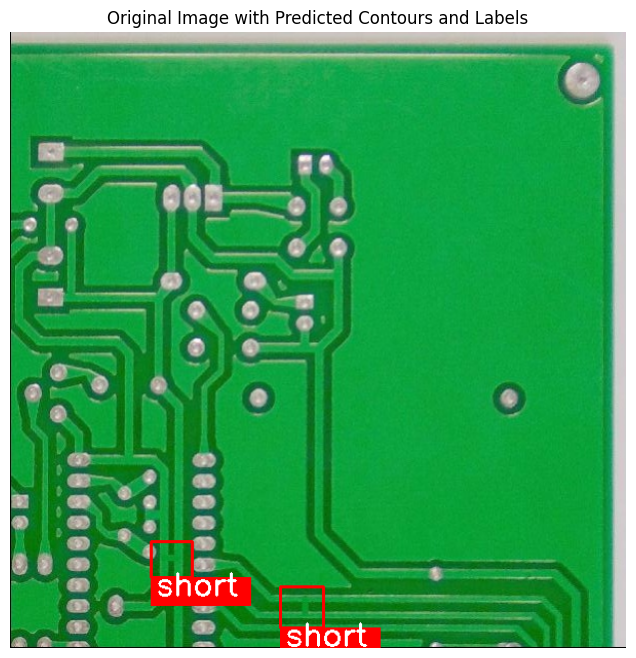

In [215]:
# Draw contours and bounding boxes on the original image_test3
output_image = image_test.copy()  # Make a copy of the original image
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

for contour, bbox, label in zip(filtered_contours, bounding_boxes, remapped_pred_label):
    if label[0] == "none":
            continue  # Skip drawing if the class label is "none"
    
    x, y, w, h = bbox
    class_label = label[0]
    
    cv2.rectangle(output_image, (x - 5, y - 5), (x + w + 5, y + h + 5), (255, 0, 0), 2)

    text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
    text_bg_size = (text_size[0] + 10, text_size[1] + 10)

    #cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 2)  # Draw contour
    #cv2.rectangle(image, (xmin, ymax), (xmin + text_bg_size[0], ymax + text_bg_size[1]), color, -1)
    cv2.rectangle(output_image, (x - 5, y + h + 5), (x + text_bg_size[0], y + h + text_bg_size[1]), (255, 0, 0), -1)  # Draw bounding box
    #draw_bboxes_with_class(image_gt, gt_bboxes, gt_class_ids, color=(0, 255, 0))
   

    # Put text (class label) below the bounding box
    cv2.putText(output_image, str(class_label), (x, y + h + text_size[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    #cv2.putText(image, class_name, (xmin + 5, ymax + text_size[1] + 5), font, font_scale, (255, 255, 255), thickness)

# Display the image with overlaid contours and bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(output_image)
plt.title('Original Image with Predicted Contours and Labels')
plt.axis('off')
plt.show()

In [216]:
# display original and result images side by side
def display_images_side_by_side(images, titles=None, figsize=(20, 20)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if titles:
            ax.set_title(title)
        ax.axis('off')
    plt.show()

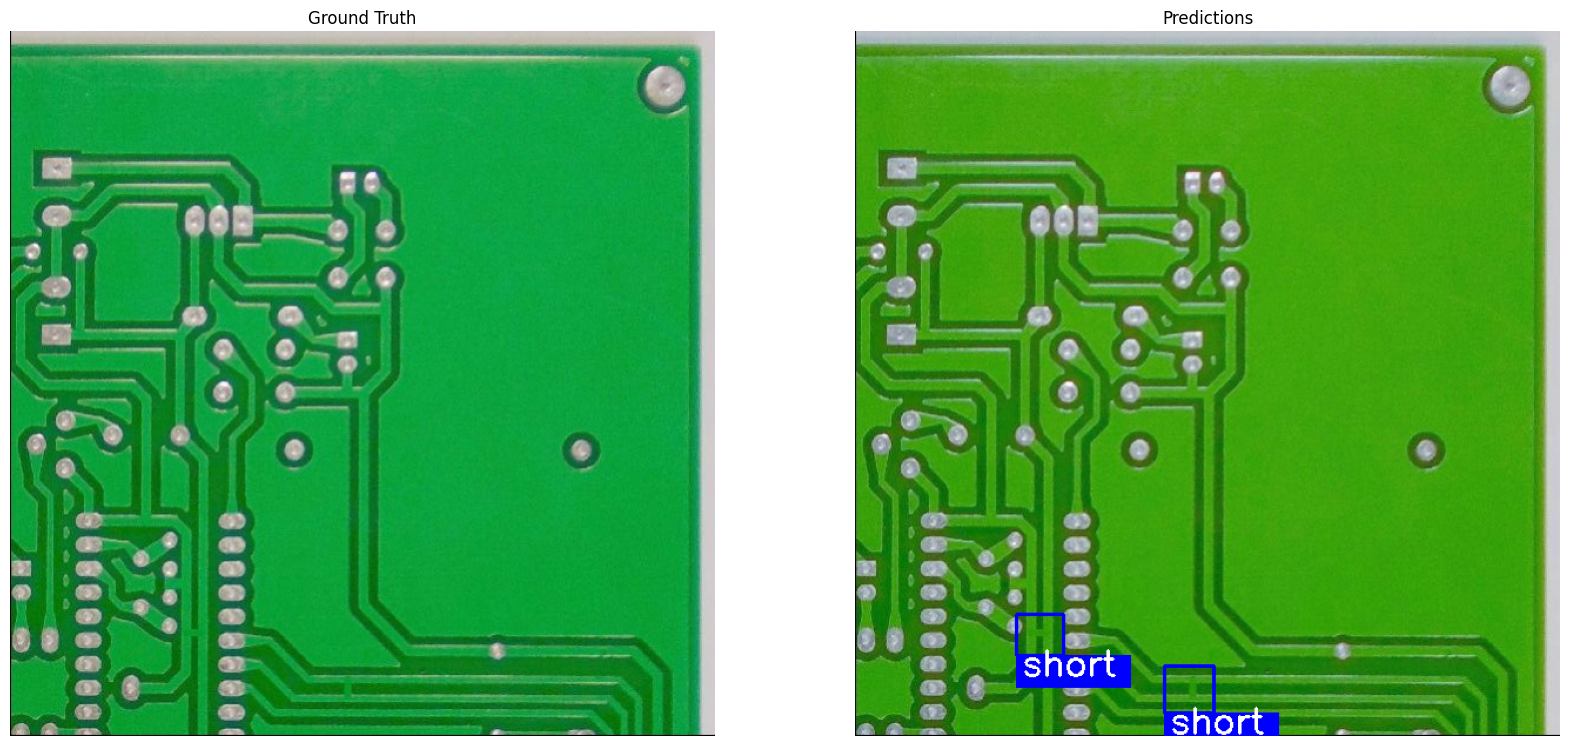

In [217]:
display_images_side_by_side([image_test, output_image], titles=['Ground Truth', 'Predictions'])